# 将观测数据加载到 Bagpipes

本示例演示如何输入观测数据。更多信息见文档中的 加载观测数据 页面 (loading observational data)。

## load_data 函数

要加载数据，需要编写一个函数，该函数接受一个 ID（字符串）并返回 Bagpipes 期望的格式的数据。

对于光度学，这个格式是一个 n x 2 的数组，包含以微 Jansky 为单位的通量和通量误差。对于光谱学，这个格式是一个 n x 3 的数组，包含以埃为单位的波长、通量和以 erg/s/cm^2/Å 为单位的通量误差。

下面给出一个从 Guo et al. (2013) 目录加载光度数据的示例 load 数据函数。该目录未包含在仓库中。

In [ ]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits

def load_goodss(ID):
    """ 从目录加载 UltraVISTA 光度数据。 """

    # 从目录中读取相关列。
    cat = np.loadtxt("data/hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # 找到目标对象对应的行。
    row = int(ID) - 1

    # 从目录中提取该对象。
    fluxes = cat[row, :15]
    fluxerrs = cat[row, 15:]

    # 将它们转换为二维数组。
    photometry = np.c_[fluxes, fluxerrs]

    # 将缺失通量的误差设为极大值。
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            
    # 对信噪比施加上限：前10个通道最大为20，IRAC通道最大为10。
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry

Bagpipes: Latex turned off in rcParams, plots may look strange.


我们用对象 17433 作为测试用例来检验是否可行。

In [2]:
print(load_goodss("17433"))

[[6.987040e-02 7.049980e-03]
 [1.923840e-01 4.059220e-02]
 [8.308090e-01 4.154045e-02]
 [2.950840e+00 1.475420e-01]
 [7.377370e+00 3.688685e-01]
 [9.502210e+00 4.751105e-01]
 [0.000000e+00 9.900000e+99]
 [1.516060e+01 7.580300e-01]
 [2.142950e+01 1.071475e+00]
 [3.460530e+01 1.730265e+00]
 [3.460900e+01 3.460900e+00]
 [5.131500e+01 5.131500e+00]
 [3.950320e+01 3.950320e+00]
 [2.687740e+01 2.687740e+00]
 [1.799710e+01 1.799710e+00]]


现在只需将 ID 和 `load_goodss` 函数传给 `pipes.galaxy` 类，并同时传入示例 1 中的 `filt_list`。

因为我们不输入任何光谱数据，还需要将关键字参数 `spectrum_exists` 设为 `False`：

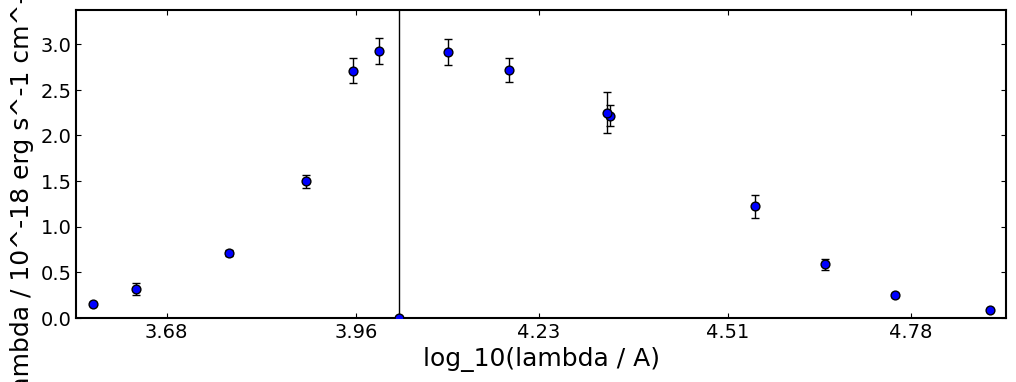

In [3]:
goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")

galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)
fig = galaxy.plot()

## 添加光谱数据

数据加载函数可以返回光度、光谱或两者。下面尝试一个包含光谱的示例。正好，上面的对象也被 VANDELS 观测过。这个目录下的 fits 文件来自 DR2。我们可以用下面的函数加载它：

In [ ]:
def bin(spectrum, binn):
    """ 将二维或三列的光谱数据按指定因子进行分箱（bin）。 """

    binn = int(binn)
    nbins = len(spectrum) // binn
    binspec = np.zeros((nbins, spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_vandels_spec(ID):
    """ 从文件加载 VANDELS 观测的光谱数据。 """

    hdulist = fits.open("data/VANDELS_CDFS_" + ID + ".fits")

    spectrum = np.c_[hdulist[1].data["WAVE"][0],
                     hdulist[1].data["FLUX"][0],
                     hdulist[1].data["ERR"][0]]

    mask = (spectrum[:,0] < 9250.) & (spectrum[:,0] > 5250.)

    return bin(spectrum[mask], 2)

这次不需要传入 `filt_list` 参数，需要将关键字参数 `photometry_exists` 设为 `False`：

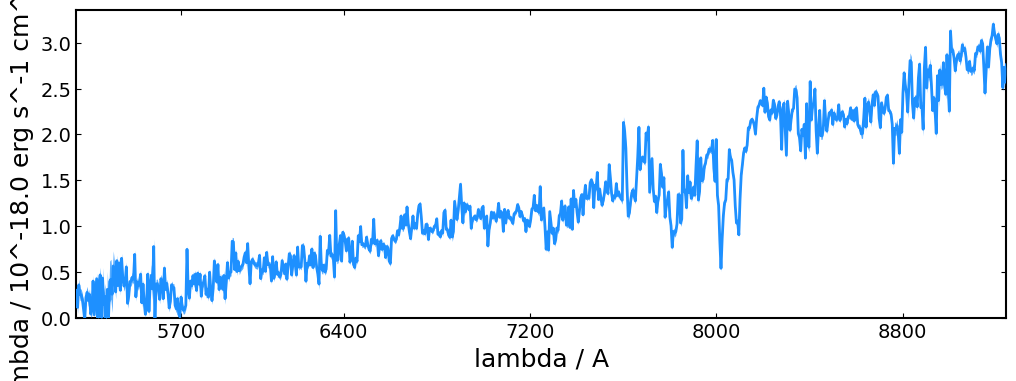

In [ ]:
galaxy = pipes.galaxy("017433", load_vandels_spec, photometry_exists=False)

fig = galaxy.plot()

## 同时加载光度和光谱数据

现在把它们合并在一起。我们可以定义一个函数，先调用 `load_vandels_spec` 再调用 `load_goodss`，并返回光谱和光度。当同时加载两种数据时，bagpipes 期望先返回光谱，然后是光度，形式如下：

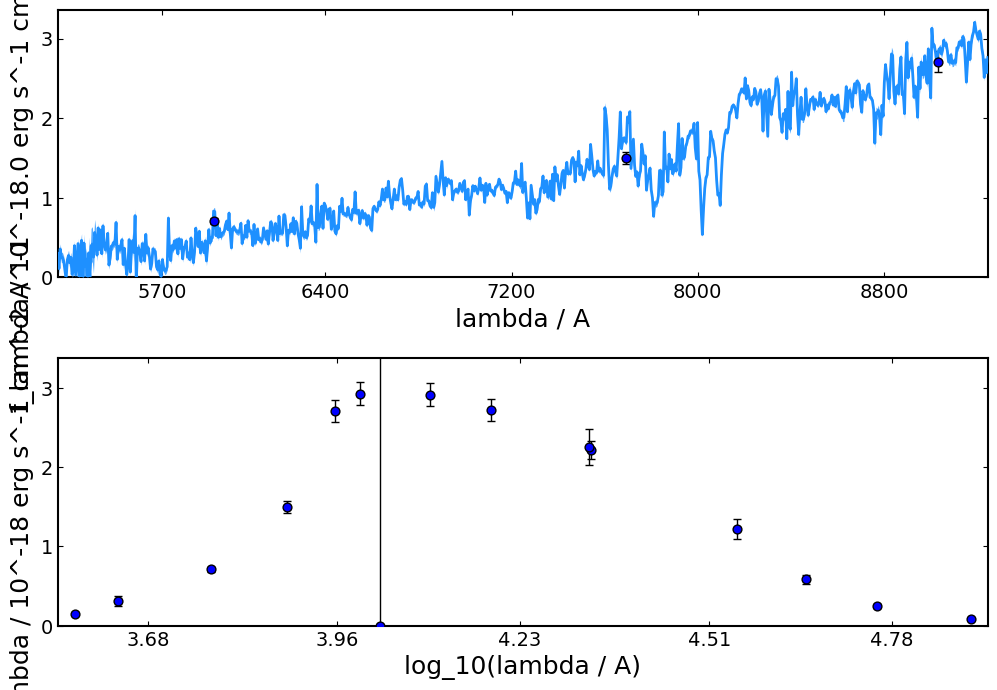

In [5]:
def load_both(ID):
    spectrum = load_vandels_spec(ID)
    phot = load_goodss(ID)

    return spectrum, phot

galaxy = pipes.galaxy("017433", load_both, filt_list=goodss_filt_list)

fig = galaxy.plot()

以上就是主要内容。你可以看到位于光谱波长范围内的光度点会绘制在上面的面板上，以便比较光谱与光度的校准是否一致。